In [5]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
#!pip install petroeval
#!pip install catboost
import catboost as cat
from catboost import CatBoostClassifier, CatBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score, f1_score, roc_auc_score, classification_report
import lightgbm as lgb
#import keras
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils
#from keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout
#from keras.optimizers import Adam

In [6]:
import petroeval as pet

In [14]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

def one_hot_encoding(traindata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        
    return traindata

def drop_columns(traindata, *args):
    
    #labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    #traindata = traindata.drop(target, axis=1)
    #testdata = testdata.drop(columns, axis=1)
        
    return traindata

def process(traindata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, 0, traindata[_])
        traindata[_] = np.where(traindata[_] == np.nan, 0, traindata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, 0, traindata[_])
        
    return traindata


def freq_encode(data, cols):
    for i in cols:
        encoding = data.groupby(i).size()
        encoding = encoding/len(data)
        data[i + '_enc'] = data[i].map(encoding)
    return data


def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).FORCE_2020_LITHOFACIES_CONFIDENCE.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    #prior = FORCE_2020_LITHOFACIES_LITHOLOGY.mean()
    #a.fillna(prior, inplace=True)
    return a

In [8]:
A = np.load('./penalty_matrix.npy')

def score(y_true, y_pred):
    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

def evaluate(model, prediction, true_label):
    feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
    plt.figure(figsize=(12,8))
    feat_imp.plot(kind='bar', title=f'Feature Importances {len(model.feature_importances_)}')
    plt.ylabel('Feature Importance Score')

In [23]:
#importing files
train = pd.read_csv('./Train.csv', sep=';')
test = pd.read_csv('./Test.csv', sep=';')

ntrain = train.shape[0]
ntest = test.shape[0]
target = train.FORCE_2020_LITHOFACIES_CONFIDENCE.copy()
df = pd.concat((train, test)).reset_index(drop=True)

In [24]:
lithology = train['FORCE_2020_LITHOFACIES_CONFIDENCE']

In [7]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                 65030: 1,
                 65000: 2,
                 80000: 3,
                 74000: 4,
                 70000: 5,
                 70032: 6,
                 88000: 7,
                 86000: 8,
                 99000: 9,
                 90000: 10,
                 93000: 11}

lithology = lithology.map(lithology_numbers)

In [25]:
print(df.shape)
cols = ['FORCE_2020_LITHOFACIES_LITHOLOGY', 'SGR', 
        'DTS', 'DCAL', 'MUDWEIGHT', 'RMIC', 'ROPA', 'RXO']
df = drop_columns(df, *cols)
print(df.shape)

(1307297, 29)
(1307297, 21)


In [26]:
df = freq_encode(df, ['FORMATION', 'WELL', 'GROUP'])
print(df.shape)
df = mean_target(df, ['FORMATION', 'WELL', 'GROUP'])
df.shape

(1307297, 24)


(1307297, 27)

In [27]:
one_hot_cols = ['GROUP']

df = one_hot_encoding(df, *one_hot_cols)
print(df.shape)

(1307297, 40)


In [28]:
df = df.drop(['FORMATION', 'WELL'], axis=1)
df.shape

df = df.fillna(-999)
data = df.copy()

train2 = data[:ntrain].copy()
target = train2.FORCE_2020_LITHOFACIES_CONFIDENCE.copy()
train2.drop(['FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1, inplace=True)

test2 = data[ntrain:].copy()
test2.drop(['FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1, inplace=True)
test2 = test2.reset_index(drop=True)

In [ ]:
train2

In [29]:
traindata = train2
testdata = test2


#using StandardScaler function to scale the numeric features 

scaler = preprocessing.StandardScaler().fit(traindata)
traindata = scaler.transform(traindata)
testdata = scaler.transform(testdata)
traindata = pd.DataFrame(traindata, columns=train2.columns)
testdata = pd.DataFrame(testdata, columns=train2.columns)
traindata.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
0,-1.694334,-0.752515,-0.228628,1.705311,0.308476,-1.069363,0.159934,0.004074,0.398579,0.271305,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
1,-1.694182,-0.752515,-0.228628,1.705155,0.308430,-1.069363,0.159969,0.004054,0.398595,0.243904,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
2,-1.694029,-0.752515,-0.228628,1.704998,0.308430,-1.069363,0.160014,0.004088,0.398614,0.114173,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
3,-1.693877,-0.752515,-0.228628,1.704842,0.308395,-1.069363,0.159988,0.004093,0.398601,0.057410,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
4,-1.693724,-0.752515,-0.228628,1.704686,0.308372,-1.069363,0.159887,0.004051,0.398567,0.023821,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279


In [30]:
#testdata = pd.DataFrame(scaler.transform(testdata))
testdata.head()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
0,-1.708273,-1.001526,-0.242627,1.719580,0.307434,-1.069363,0.159947,0.002170,0.399410,0.034024,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
1,-1.708121,-1.001526,-0.242627,1.719423,0.307434,-1.069363,0.159737,0.001944,0.399412,0.036049,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
2,-1.707969,-1.001526,-0.242627,1.719267,0.307434,-1.069363,0.159004,0.001874,0.399382,0.121541,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
3,-1.707816,-1.001526,-0.242627,1.719111,0.307434,-1.069363,0.158150,0.001872,0.399355,0.286915,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279
4,-1.707664,-1.001525,-0.242627,1.718955,0.307434,-1.069363,0.157771,0.001853,0.399329,0.314077,...,-0.109678,-0.578044,3.082012,-0.356433,-0.048898,-0.499901,-0.032102,-0.151066,-0.356516,-0.10279


In [31]:
x_train, x_test, y_train, y_test = ms.train_test_split(traindata, lithology, test_size=0.25, random_state=42)
x_test1, x_test2, y_test1, y_test2 = ms.train_test_split(x_test, y_test, test_size=0.25, random_state=42)

In [32]:
traindata.shape, testdata.shape

((1170511, 37), (136786, 37))

In [ ]:
'''
    After preparing your data from the above steps, model training can now happen.
    
    Using the sequential method imported from keras.model,
    a sequential Artificial Neural Network will be built
'''
#creating an instance of the sequential class
model4 = Sequential()

'''
    using model.add, we add layers to the model.
    
    Different types of layers exist, you find them all on the TensorFlow Keras documentations page
    The Dense layer is used for all layers in the model and it takes in a number of arguments.
    
    The first layer is the input layer
    and it is the only layer that takes the input_dim argument, the value should be the number of
    features/columns of data being passed into the model
    
    The model contains a total of four layers( 3 hidden layers and 1 output). The input layer is
    usually not counted as a layer
    
    args: The first parameter (number) refers to the number of neurons in that layer,
          it is also referred to as the number of outputs from that layer
          
    activation: Activation refers to the mathematical function/operation you want to 
                perform on the inputs coming into the layer before outputing it to the next layer
'''
#adding the layers to the models
model4.add(Dense(60, input_dim=37, kernel_initializer='normal', activation='relu'))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(20, activation='relu'))
model4.add(Dense(12, activation='softmax', kernel_initializer='normal'))

'''
    model.compile is used to 'compile' the model for training, by cobining all layers together
    with the selected optimizer and loss metric to be used for training
    
    The Adam optimizer is used, other optimizer like SGD (Stochastic Gradient Descent) 
    occurs too but quite situable for specific tasks
'''

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, verbose=2)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=2)

In [ ]:
def baseline_model():
  model = Sequential()
  model.add(Dense(60, input_dim=37, kernel_initializer='normal', activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(20, activation='relu'))
  model.add(Dense(12, activation='softmax', kernel_initializer='normal'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	
  return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=2, batch_size=20, verbose=2)
kfold = KFold(n_splits=, shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

ValueError: ignored

In [ ]:
t1 = baseline_model().predict(x_test1)

In [ ]:
t1

array([[0.0831885 , 0.08441088, 0.08099411, ..., 0.08415549, 0.08016562,
        0.08145522],
       [0.08405408, 0.0834645 , 0.08339377, ..., 0.08209394, 0.07994816,
        0.08491755],
       [0.08341796, 0.08109862, 0.08116025, ..., 0.0832652 , 0.07721305,
        0.08573175],
       ...,
       [0.08397149, 0.08338095, 0.08299643, ..., 0.08009658, 0.07944483,
        0.08641598],
       [0.0816773 , 0.08243491, 0.06920546, ..., 0.09635916, 0.07244556,
        0.07957997],
       [0.08486737, 0.08392802, 0.08035327, ..., 0.08549654, 0.07739875,
        0.08560099]], dtype=float32)

In [ ]:
model4.fit(x_train, y_train, batch_size=10, validation_data = [(x_test1,y_test1)], callbacks=[callback], epochs=10, shuffle=True, verbose=2)

Epoch 1/10


ValueError: ignored

In [ ]:
class Model():
    
    def __init__(self, train, test, label):
        
        
        self.train = train
        self.test = test
        self.label = label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
        
        #SPLIT ONE

        self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.label)), 
                                                                                   test_size=0.25,
                                                                                   random_state=42)

            #SPLIT TWO

        self.x_test1, self.x_test2, self.y_test1, self.y_test2 = ms.train_test_split(self.x_test,
                                                                                     self.y_test,
                                                                                     test_size=0.5,
                                                                                     random_state=42)

        lgbm = CatBoostClassifier(n_estimators=50000, max_depth=6, 
                                  random_state=42, learning_rate=0.033,
                                  use_best_model=True, task_type='GPU',
                                  eval_metric='MultiClass')

        def show_evaluation(pred, true):

            print(f'Default score: {score(true.values, pred)}')
            print(f'Accuracy is: {accuracy_score(true, pred)}')
            print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

        split = 5
        kf = StratifiedKFold(n_splits=split, shuffle=False)

        #TEST DATA
        pred_test = np.zeros((len(self.x_test1), 12))
        pred_val = np.zeros((len(self.x_test2), 12))
        open_test_pred = np.zeros((len(self.test), 12))
                  
        for (train_index, test_index) in kf.split(pd.DataFrame(self.x_train), pd.DataFrame(self.y_train)):
            X_train,X_test = pd.DataFrame(self.x_train).iloc[train_index], pd.DataFrame(self.x_train).iloc[test_index]
            y_train,y_test = pd.DataFrame(self.y_train).iloc[train_index],pd.DataFrame(self.y_train).iloc[test_index]
            lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_set=[(X_test,y_test)])
            #scores.append(metric(lgbm.predict_proba(X_test),y_test))
            pred_test+=lgbm.predict_proba(self.x_test1)
            pred_val+=lgbm.predict_proba(self.x_test2)
            open_test_pred+=lgbm.predict_proba(self.test)


        pred_test_avg = pd.DataFrame(pred_test/split)
        pred_val_avg = pd.DataFrame(pred_val/split)
        open_test_avg = pd.DataFrame(open_test_pred/split)

        test_result = np.array(pred_test_avg.idxmax(axis=1))
        val_result = np.array(pred_val_avg.idxmax(axis=1))
        open_result = np.array(open_test_avg.idxmax(axis=1))


        

        print('----------------TEST EVALUATION------------------')
        show_evaluation(test_result, self.y_test1)

        print('----------------HOLD OUT EVALUATION------------------')
        show_evaluation(val_result, self.y_test2)
                  
        if plot: self.plot_feat_imp(lgbm)
        return open_result, lgbm
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
class Model():
    
    def __init__(self, train, test, label):
        
        
        self.train = train
        self.test = test
        self.label = label
        
    def __call__(self, plot = True):
        return self.fit(plot)
    
    def fit(self, plot):
        
        #SPLIT ONE

        self.x_train, self.x_test, self.y_train, self.y_test = ms.train_test_split(self.train, 
                                                                                   pd.DataFrame(np.array(self.label)), 
                                                                                   test_size=0.25,
                                                                                   random_state=42)

            #SPLIT TWO

        self.x_test1, self.x_test2, self.y_test1, self.y_test2 = ms.train_test_split(self.x_test,
                                                                                     self.y_test,
                                                                                     test_size=0.5,
                                                                                     random_state=42)

        lgbm = CatBoostClassifier(n_estimators=50000, max_depth=6, 
                                  random_state=42, learning_rate=0.033,
                                  use_best_model=True, task_type='GPU',
                                  eval_metric='MultiClass')

        def show_evaluation(pred, true):

            print(f'Default score: {score(true.values, pred)}')
            print(f'Accuracy is: {accuracy_score(true, pred)}')
            print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

        #TEST DATA
        pred_test = np.zeros((len(self.x_test1), 12))
        pred_val = np.zeros((len(self.x_test2), 12))
        open_test_pred = np.zeros((len(self.test), 12))
        
        lgbm.fit(self.x_train, self.y_train, early_stopping_rounds=100, eval_set=[(self.x_test1, self.y_test1)])
        #scores.append(metric(lgbm.predict_proba(X_test),y_test))
        pred_test=lgbm.predict_proba(self.x_test1)
        pred_val=lgbm.predict_proba(self.x_test2)
        open_test_pred=lgbm.predict_proba(self.test)


        pred_test_avg = pd.DataFrame(pred_test)
        pred_val_avg = pd.DataFrame(pred_val)
        open_test_avg = pd.DataFrame(open_test_pred)

        test_result = np.array(pred_test_avg.idxmax(axis=1))
        val_result = np.array(pred_val_avg.idxmax(axis=1))
        open_result = np.array(open_test_avg.idxmax(axis=1))


        

        print('----------------TEST EVALUATION------------------')
        show_evaluation(test_result, self.y_test1)

        print('----------------HOLD OUT EVALUATION------------------')
        show_evaluation(val_result, self.y_test2)
                  
        if plot: self.plot_feat_imp(lgbm)
        return open_result, lgbm
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

Streaming output truncated to the last 5000 lines.
45011:	learn: 0.0999107	test: 0.1486144	best: 0.1486144 (45011)	total: 1h 4m 41s	remaining: 7m 10s
45012:	learn: 0.0999099	test: 0.1486140	best: 0.1486140 (45012)	total: 1h 4m 41s	remaining: 7m 10s
45013:	learn: 0.0999090	test: 0.1486141	best: 0.1486140 (45012)	total: 1h 4m 41s	remaining: 7m 9s
45014:	learn: 0.0999080	test: 0.1486135	best: 0.1486135 (45014)	total: 1h 4m 42s	remaining: 7m 9s
45015:	learn: 0.0999070	test: 0.1486134	best: 0.1486134 (45015)	total: 1h 4m 42s	remaining: 7m 9s
45016:	learn: 0.0999057	test: 0.1486124	best: 0.1486124 (45016)	total: 1h 4m 42s	remaining: 7m 9s
45017:	learn: 0.0999035	test: 0.1486111	best: 0.1486111 (45017)	total: 1h 4m 42s	remaining: 7m 9s
45018:	learn: 0.0999015	test: 0.1486087	best: 0.1486087 (45018)	total: 1h 4m 42s	remaining: 7m 9s
45019:	learn: 0.0998998	test: 0.1486081	best: 0.1486081 (45019)	total: 1h 4m 42s	remaining: 7m 9s
45020:	learn: 0.0998989	test: 0.1486082	best: 0.1486081 (45019)	t

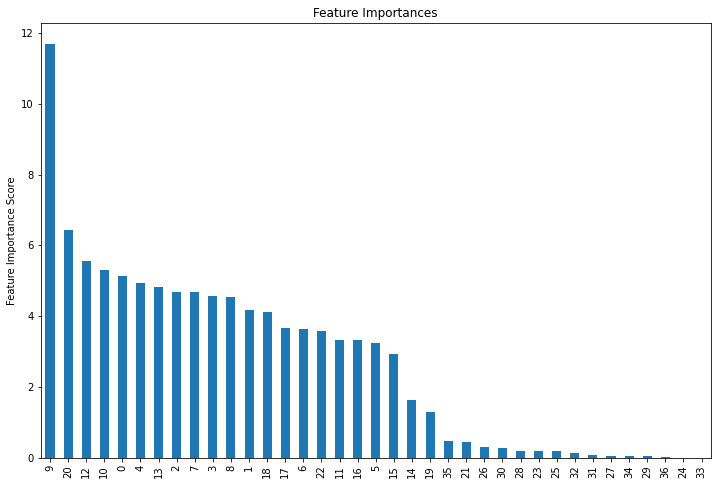

In [ ]:
func_= Model(traindata, testdata, lithology)
open_pred, model = func_()
make_submission(open_pred, filename='CATBOOST1-(UNKNOWN1)')

In [35]:
#traindata = pd.DataFrame(traindata, columns=train2.columns)
traindata.isna().sum()

DEPTH_MD                  0
X_LOC                     0
Y_LOC                     0
Z_LOC                     0
CALI                      0
RSHA                      0
RMED                      0
RDEP                      0
RHOB                      0
GR                        0
NPHI                      0
PEF                       0
DTC                       0
SP                        0
BS                        0
ROP                       0
DRHO                      0
FORMATION_enc             0
WELL_enc                  0
GROUP_enc                 0
FORMATION_mean_target     0
WELL_mean_target          0
GROUP_mean_target         0
GROUP_BAAT GP.            0
GROUP_BOKNFJORD GP.       0
GROUP_CROMER KNOLL GP.    0
GROUP_DUNLIN GP.          0
GROUP_HEGRE GP.           0
GROUP_HORDALAND GP.       0
GROUP_NORDLAND GP.        0
GROUP_ROGALAND GP.        0
GROUP_ROTLIEGENDES GP.    0
GROUP_SHETLAND GP.        0
GROUP_TYNE GP.            0
GROUP_VESTLAND GP.        0
GROUP_VIKING GP.    

In [50]:
traindata.describe()

,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,...,GROUP_HEGRE GP.,GROUP_HORDALAND GP.,GROUP_NORDLAND GP.,GROUP_ROGALAND GP.,GROUP_ROTLIEGENDES GP.,GROUP_SHETLAND GP.,GROUP_TYNE GP.,GROUP_VESTLAND GP.,GROUP_VIKING GP.,GROUP_ZECHSTEIN GP.
count,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,...,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06,1.170511e+06
mean,3.797611e-16,-5.216850e-13,-7.600893e-14,-9.499876e-15,-2.765990e-14,1.695025e-13,2.871772e-14,3.456052e-15,1.653729e-14,5.549697e-16,...,1.191698e-14,-9.024278e-13,1.033391e-12,-4.570949e-13,7.707317e-13,-2.626953e-13,-3.433544e-13,1.272045e-12,-2.279337e-12,-1.198743e-12
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.053789e+00,-8.339007e+00,-1.017335e+01,-3.359680e+00,-3.509639e+00,-1.069363e+00,-5.162025e+00,-6.687969e+00,-2.501624e+00,-2.068401e+00,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
25%,-7.676537e-01,-4.614751e-01,-4.442049e-02,-6.955939e-01,2.687129e-01,-1.069363e+00,1.559967e-01,-1.959346e-03,3.989156e-01,-6.802652e-01,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
50%,-1.077857e-01,-7.367394e-02,1.726648e-01,1.002723e-01,2.820429e-01,8.954781e-01,1.588131e-01,1.596436e-03,3.996207e-01,-7.437794e-02,...,-1.096779e-01,-5.780438e-01,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
75%,6.822283e-01,6.741769e-01,2.537118e-01,7.759782e-01,2.944868e-01,8.973639e-01,1.651232e-01,9.016794e-03,4.002558e-01,5.293906e-01,...,-1.096779e-01,1.729973e+00,-3.244634e-01,-3.564327e-01,-4.889771e-02,-4.999009e-01,-3.210180e-02,-1.510655e-01,-3.565164e-01,-1.027897e-01
max,3.261738e+00,1.582211e+00,3.640139e-01,2.073835e+00,3.414585e-01,5.207002e+00,1.072823e+01,1.336470e+01,4.031385e-01,2.938963e+01,...,9.117606e+00,1.729973e+00,3.082012e+00,2.805579e+00,2.045085e+01,2.000396e+00,3.115090e+01,6.619644e+00,2.804920e+00,9.728598e+00


In [68]:
x_train, x_test, y_train, y_test = ms.train_test_split(traindata, lithology, test_size=0.2, random_state=42)
x_test1, x_test2, y_test1, y_test2 = ms.train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [51]:
traindata = process(traindata)
testdata = process(testdata)

In [64]:
lithology1 = []
j = 0
for i in lithology:
    if i<0:
        j = 0
    elif i == np.NaN:
        j == 1
    else:
        j = i
    lithology1.append(int(j))

ValueError: cannot convert float NaN to integer

In [67]:
lithology1.describe()

AttributeError: 'list' object has no attribute 'describe'

In [69]:
model = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', verbose=2)
model.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
def show_evaluation(pred, true):
  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [ ]:
test_result = model.predict_proba(x_test1)
val_result = model.predict_proba(x_test2)

pred_test_avg = pd.DataFrame(test_result)
pred_val_avg = pd.DataFrame(val_result)
#open_test_avg = pd.DataFrame(open_test_pred)

test_result = np.array(pred_test_avg.idxmax(axis=1))
val_result = np.array(pred_val_avg.idxmax(axis=1))
#open_result = np.array(open_test_avg.idxmax(axis=1))

print('----------------TEST EVALUATION------------------')
show_evaluation(test_result, y_test1)

print('----------------HOLD OUT EVALUATION------------------')
show_evaluation(val_result, y_test2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    1.5s finished


----------------TEST EVALUATION------------------
Default score: -0.10644230900665691
Accuracy is: 0.9611702685092791
F1 is: 0.9615758925352559
----------------TEST EVALUATION------------------
Default score: -0.1066849378733409
Accuracy is: 0.9614801044329319
F1 is: 0.9619217827827912


Text(0, 0.5, 'Feature Importance Score')

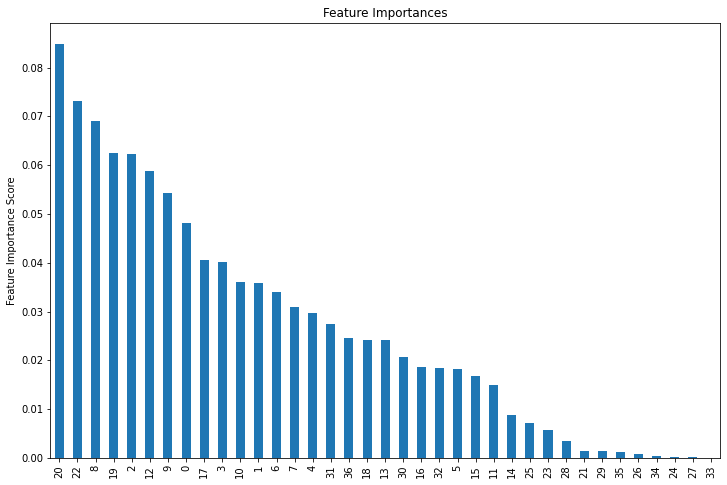

In [ ]:
feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
for i, j in enumerate(testdata.columns):
  print (i,j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DRHO
17 FORMATION_enc
18 WELL_enc
19 GROUP_enc
20 FORMATION_mean_target
21 WELL_mean_target
22 GROUP_mean_target
23 GROUP_BAAT GP.
24 GROUP_BOKNFJORD GP.
25 GROUP_CROMER KNOLL GP.
26 GROUP_DUNLIN GP.
27 GROUP_HEGRE GP.
28 GROUP_HORDALAND GP.
29 GROUP_NORDLAND GP.
30 GROUP_ROGALAND GP.
31 GROUP_ROTLIEGENDES GP.
32 GROUP_SHETLAND GP.
33 GROUP_TYNE GP.
34 GROUP_VESTLAND GP.
35 GROUP_VIKING GP.
36 GROUP_ZECHSTEIN GP.


In [ ]:
x_train, x_test, y_train, y_test = ms.train_test_split(traindata, lithology, test_size=0.25,
                                                       random_state=42, stratify=lithology)

x_test1, x_test2, y_test1, y_test2 = ms.train_test_split(x_test, y_test, test_size=0.5,
                                                       random_state=42, stratify=y_test)

In [ ]:
x_train.shape, x_test1.shape, x_test2.shape

((877883, 37), (146314, 37), (146314, 37))

In [ ]:
for i, j in enumerate(train2.columns):
  print(i, j)

0 DEPTH_MD
1 X_LOC
2 Y_LOC
3 Z_LOC
4 CALI
5 RSHA
6 RMED
7 RDEP
8 RHOB
9 GR
10 NPHI
11 PEF
12 DTC
13 SP
14 BS
15 ROP
16 DRHO
17 FORMATION_enc
18 WELL_enc
19 GROUP_enc
20 FORMATION_mean_target
21 WELL_mean_target
22 GROUP_mean_target
23 GROUP_BAAT GP.
24 GROUP_BOKNFJORD GP.
25 GROUP_CROMER KNOLL GP.
26 GROUP_DUNLIN GP.
27 GROUP_HEGRE GP.
28 GROUP_HORDALAND GP.
29 GROUP_NORDLAND GP.
30 GROUP_ROGALAND GP.
31 GROUP_ROTLIEGENDES GP.
32 GROUP_SHETLAND GP.
33 GROUP_TYNE GP.
34 GROUP_VESTLAND GP.
35 GROUP_VIKING GP.
36 GROUP_ZECHSTEIN GP.


In [ ]:
 def make_submission(train, test)       
        
        test_result = np.array(pred_test_avg.idxmax(axis=1))
        val_result = np.array(pred_val_avg.idxmax(axis=1))
        open_result = np.array(open_test_avg.idxmax(axis=1))


        

        print('----------------TEST EVALUATION------------------')
        show_evaluation(test_result, self.y_test1)

        print('----------------HOLD OUT EVALUATION------------------')
        show_evaluation(val_result, self.y_test2)
                  
        if plot: self.plot_feat_imp(lgbm)
        return open_result, lgbm
              
              
    def plot_feat_imp(self, model):
        feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
        plt.figure(figsize=(12,8))
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [ ]:
def make_submission(prediction, filename):

  path = '/content/drive/My Drive/FORCE-Lithology-Prediction/'

  test = pd.read_csv('/content/drive/My Drive/FORCE-Lithology-Prediction/Test.csv', sep=';')
  #test_prediction = model.predict(testdata)

  #test_prediction
  category_to_lithology = {y:x for x,y in lithology_numbers.items()}
  test_prediction_for_submission = np.vectorize(category_to_lithology.get)(prediction)
  np.savetxt(path+filename+'.csv', test_prediction_for_submission, header='lithology', fmt='%i')
  

In [ ]:
make_submission(open_pred, filename='CATBOOST1-(UNKNOWN)xxx')

In [ ]:
n1 = df1.idxmax(axis=1)

In [ ]:
n1

0         2
1         2
2         2
3         2
4         2
         ..
136781    1
136782    1
136783    1
136784    1
136785    1
Length: 136786, dtype: int64

In [ ]:
np.array(n1)

array([2, 2, 2, ..., 1, 1, 1])